In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [31]:
# Загрузка данных
data_lec = pd.read_csv('data_lec.csv')
target_lec = pd.read_csv('target_lec.csv')

In [3]:
data_lec.head()

,Unnamed: 0,timestamp,ppm1,temp1,temp2,ppm2,gas_opening1,press1,rotationspeed1,press3,...,SIM2,LSF2,electric_ampere2,electric_ampere3,temp5,target,target_ffill,electric_ampere_delta1,coeffs_current1,coeffs_temp1
0,0,2023-09-04 05:01:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006982,NaN,NaN
1,1,2023-09-04 05:02:00+00:00,NaN,767.616089,301.616760,NaN,4.334852,0.338180,0.0,0.0,...,NaN,NaN,27.0,NaN,781.098145,NaN,NaN,0.018020,NaN,NaN
2,2,2023-09-04 05:03:00+00:00,NaN,767.758545,302.511932,NaN,4.304109,0.388817,0.0,0.0,...,NaN,NaN,27.0,NaN,781.050659,NaN,NaN,0.015809,NaN,NaN
3,3,2023-09-04 05:04:00+00:00,NaN,767.806030,303.645836,NaN,4.303205,0.353552,0.0,0.0,...,NaN,NaN,27.0,NaN,781.050659,NaN,NaN,0.013946,NaN,NaN
4,4,2023-09-04 05:05:00+00:00,NaN,767.806000,304.222733,NaN,4.290545,0.349031,0.0,0.0,...,NaN,NaN,27.0,NaN,780.870209,NaN,NaN,0.023489,NaN,NaN


In [4]:
target_lec.head()

,timestamp,target
0,2023-09-06 07:17:00+00:00,0.99480
1,2023-09-06 08:46:00+00:00,1.98218
2,2023-09-06 11:24:00+00:00,2.29000
3,2023-09-06 13:21:00+00:00,2.13000
4,2023-09-06 14:53:00+00:00,1.15249


In [32]:
# Преобразование временных меток в datetime
data_lec['timestamp'] = pd.to_datetime(data_lec['timestamp'])
target_lec['timestamp'] = pd.to_datetime(target_lec['timestamp'])

In [33]:
# Интерполяция значений target до временного разрешения data_lec
target_lec = target_lec.set_index('timestamp').reindex(data_lec['timestamp'], method='nearest').interpolate()

data_lec = data_lec.set_index('timestamp')
data = data_lec.join(target_lec, how='inner', rsuffix='_target')

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 81255 entries, 2023-09-04 05:01:00+00:00 to 2023-10-30 05:00:00+00:00
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              81255 non-null  int64  
 1   ppm1                    80284 non-null  float64
 2   temp1                   80639 non-null  float64
 3   temp2                   80639 non-null  float64
 4   ppm2                    80284 non-null  float64
 5   gas_opening1            80639 non-null  float64
 6   press1                  80639 non-null  float64
 7   rotationspeed1          80639 non-null  float64
 8   press3                  80639 non-null  float64
 9   temp3                   80639 non-null  float64
 10  press2                  80639 non-null  float64
 11  press4                  80639 non-null  float64
 12  temp4                   80639 non-null  float64
 13  electric_ampere1        80639 non-null  floa

In [18]:
data.describe()

,Unnamed: 0,ppm1,temp1,temp2,ppm2,gas_opening1,press1,rotationspeed1,press3,temp3,...,LSF2,electric_ampere2,electric_ampere3,temp5,target,target_ffill,electric_ampere_delta1,coeffs_current1,coeffs_temp1,target_target
count,81255.000000,80284.000000,80639.000000,80639.000000,80284.000000,80639.000000,80639.000000,80639.000000,80639.000000,80639.000000,...,79929.000000,80639.000000,64820.000000,80639.000000,622.000000,64576.000000,74536.000000,74070.000000,80619.000000,81255.000000
mean,40627.000000,1497.049701,759.162893,824.706563,8.584342,68.754007,63.349714,20.227902,88.044516,23.428025,...,97.974751,50.642667,57.456088,793.081139,1.743725,1.581992,11.534969,0.002126,0.006764,0.927231
std,23456.442399,608.930252,162.119881,212.539937,4.409426,20.948000,19.816016,25.335950,32.765217,6.872253,...,2.295399,8.144591,5.764125,165.442847,1.240274,1.002550,9.853059,0.556604,1.844786,0.511077
min,0.000000,-1691.106445,-1.000000,-1.000000,-22.222222,-1.229745,-1.066985,-1.000000,-1.000000,-1.000000,...,33.031781,-1.000000,0.000000,-1.000000,0.194990,0.194990,0.000000,-3.975029,-16.710137,0.230840
25%,20313.500000,1340.092102,771.698669,842.664917,5.843099,74.129958,68.537506,0.000000,78.250000,18.473312,...,96.719722,51.000000,57.321392,809.714111,0.983770,0.982580,5.416000,-0.293087,-0.931308,0.750710
50%,40627.000000,1732.878296,799.317749,887.951218,7.262732,76.810255,71.175129,0.000000,94.750000,22.365990,...,98.087946,53.750000,58.702271,832.842285,1.435540,1.359290,10.081696,-0.000073,-0.023266,0.750710
75%,60940.500000,1955.211700,821.107323,925.007709,9.527362,78.288666,72.891346,54.992676,108.500000,27.967667,...,99.117176,55.000000,59.863274,845.849579,2.166660,1.969330,16.209549,0.271852,0.966144,0.750710
max,81254.000000,2005.786255,1006.608124,1063.934143,21.554904,83.208549,79.305316,99.993889,197.250000,41.791443,...,109.235917,62.000000,520.747161,1012.057800,9.535660,9.535660,426.318306,3.910303,17.239887,7.309020


In [34]:
# Удаление неинформативных столбцов
data = data.drop(columns=['Unnamed: 0'])

In [35]:
# Заполнение пропусков
print("Missing values before handling:")
print(data.isnull().sum())
data = data.fillna(method='ffill').fillna(method='bfill')

Missing values before handling:
ppm1                        971
temp1                       616
temp2                       616
ppm2                        971
gas_opening1                616
press1                      616
rotationspeed1              616
press3                      616
temp3                       616
press2                      616
press4                      616
temp4                       616
electric_ampere1            616
speed1                      616
press5                      616
electric_consumption2       616
press6                      616
speed2                      616
electric_consumption3       616
inlet_pressure1             616
press7                      616
gas_consumption1            616
press8                      616
press9                      616
electric_consumption4       616
electric_consumption5       616
press10                     616
sito1                      1135
moisture1                  1135
ALM1                       1135
CaO1    

<ipython-input-35-9777297c0fa2>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [36]:
# Создание лаговых признаков
lag_features = ['ppm1', 'temp1', 'temp2', 'gas_opening1', 'press1']
for feature in lag_features:
    for lag in range(1, 6):  # Лаги от 1 до 5 минут
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)

# Создание признаков для прогноз на 15 минут
data['target_15min'] = data['target'].shift(-15)
data = data.dropna()

# Моделирование изменения gas_consumption1 на +150
data['gas_consumption1_future'] = data['gas_consumption1'] + 150
data['target_simulated'] = data['target'].shift(-15)
data = data.dropna()

<ipython-input-36-30ffc8bec1c0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gas_consumption1_future'] = data['gas_consumption1'] + 150
<ipython-input-36-30ffc8bec1c0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target_simulated'] = data['target'].shift(-15)


In [37]:
X_15min = data.drop(columns=['target', 'target_15min', 'target_simulated', 'gas_consumption1_future'])
y_15min = data['target_15min']

X_train_15min, X_test_15min, y_train_15min, y_test_15min = train_test_split(X_15min, y_15min, test_size=0.2, random_state=42)

X_simulated = data.drop(columns=['target', 'target_simulated', 'target_15min'])
y_simulated = data['target_simulated']

X_train_simulated, X_test_simulated, y_train_simulated, y_test_simulated = train_test_split(X_simulated, y_simulated, test_size=0.2, random_state=42)

In [38]:
# Обучение моделей
model_15min = RandomForestRegressor(n_estimators=100, random_state=42)
model_15min.fit(X_train_15min, y_train_15min)

model_simulated = RandomForestRegressor(n_estimators=100, random_state=42)
model_simulated.fit(X_train_simulated, y_train_simulated)

RandomForestRegressor(random_state=42)

In [39]:
# Оценка модели для задачи 2
predictions_15min = model_15min.predict(X_test_15min)
mse_15min = mean_squared_error(y_test_15min, predictions_15min)
mae_15min = mean_absolute_error(y_test_15min, predictions_15min)

print(f"Task 2 - Forecasting 15min: MSE: {mse_15min}, MAE: {mae_15min}")

Task 2 - Forecasting 15min: MSE: 0.009936070379294774, MAE: 0.020175661284167798


In [40]:
# Оценка модели для задачи 3
predictions_simulated = model_simulated.predict(X_test_simulated)
mse_simulated = mean_squared_error(y_test_simulated, predictions_simulated)
mae_simulated = mean_absolute_error(y_test_simulated, predictions_simulated)

print(f"Task 3 - Simulated Impact: MSE: {mse_simulated}, MAE: {mae_simulated}")

Task 3 - Simulated Impact: MSE: 0.010013971650427202, MAE: 0.020269313032505672


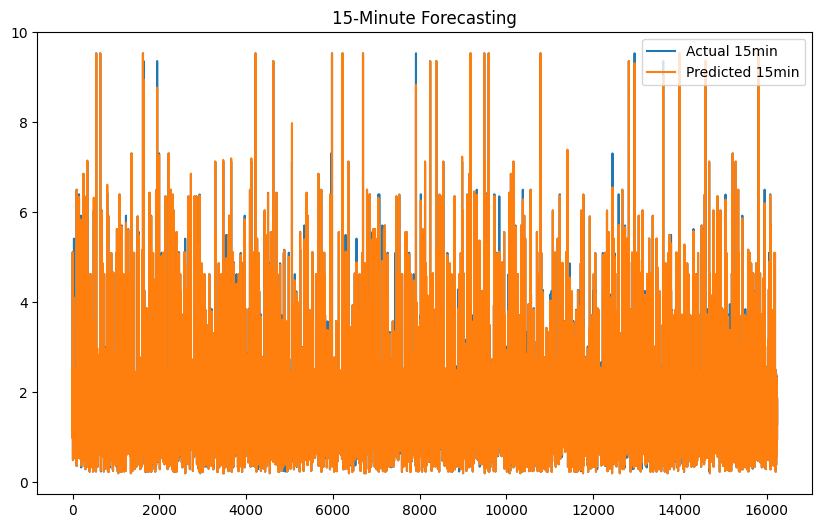

In [41]:
# Визуализация результатов задачи 2
plt.figure(figsize=(10, 6))
plt.plot(y_test_15min.values, label='Actual 15min')
plt.plot(predictions_15min, label='Predicted 15min')
plt.legend()
plt.title('15-Minute Forecasting')
plt.show()

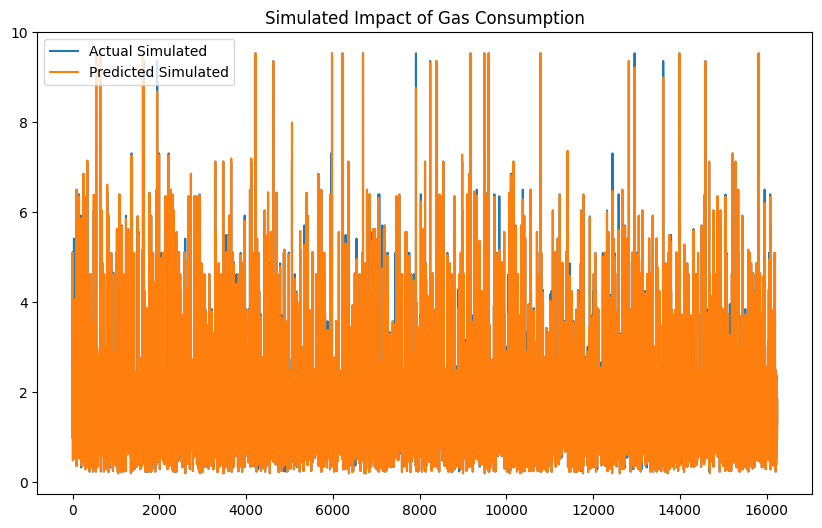

In [42]:
# Визуализация результатов задачи 3
plt.figure(figsize=(10, 6))
plt.plot(y_test_simulated.values, label='Actual Simulated')
plt.plot(predictions_simulated, label='Predicted Simulated')
plt.legend()
plt.title('Simulated Impact of Gas Consumption')
plt.show()